# Sentiment Analysis of Tweets

Sentiment Analysis of the tweets written in Slavic languages (Bosnian, Serbian and Croatian) on CLARIN.SI dataset. 

## Connect to google drive

Connect to google drive so that we can save checkpoints and load the data

In [1]:
from google.colab import drive
drive.mount('/content/google_drive')

Mounted at /content/google_drive


Change to directory where the notebook is located

In [2]:
%cd /content/google_drive/MyDrive/Colab\ Notebooks/Sentiment-Analysis-Roberta
%ls

/content/google_drive/MyDrive/Colab Notebooks/Sentiment-Analysis-Roberta
 checkpoints/          keys.txt               SA_dataset1.ipynb
 checkpoint_utils.py   model_utils.py         SA_dataset2.ipynb
 data/                 plot_utils.py          twitter_api_utils.py
 dataset.py           'previous notebooks'/
 dataset_utils.py      __pycache__/


In [3]:
import os
data_path = os.path.join(os.getcwd(),'data','dataset1')

## Extract text of the tweet given tweet id

In [ ]:
import os
import tweepy
import pandas as pd
import numpy as np
import sys
from twitter_api_utils import get_keys, get_tweet, extract_tweets, connect_to_API

Connect to Twitter API using authentication keys

In [ ]:
path_keys = os.path.join(os.getcwd(),'keys.txt')
api = connect_to_API(path_keys)

Extract the tweets given tweets ID and save them in the .csv format on Google Drive.

In [ ]:
extract_tweets(api,'Croatian', data_path, start_row=0)

In [ ]:
extract_tweets(api,'Serbian', data_path,start_row=0)

In [ ]:
extract_tweets(api,'Bosnian', data_path,start_row=0)

## Concatenate and preprocess csv files

Since fetching the text of the tweets from Twitter API consumes a lot of time (it is counted in days) we need to concatenate multiple .csv files from every session.<br />
**PREPROCESSING:**<br />
1. There are a lot of NaN rows, because multiple tweets are deleted, so they are dropped.
1. Because some of the tweets were annotated multiple times by the same annotator, there can be duplicated rows. We first need to drop all rows, but one, with duplicated tweets where *HandLabel* is the same. After that we drop all duplicated tweets, since they all have different *HandLabel* and we do not know which one is correct. It would have been wrong if we dropped all the duplicates at once, without looking at the *HandLabel*, because we would threw away the highest quality data (the tweets which were labeled same multiple times).
2. All tweets are converted to lowercase
3. All links were removed since they do not contain any relevant information for this task and also '[video]' and '{link}' strings were removed because Twitter sometimes converts links to to these keywords.
4. A lot of tweets are usually retweets, that means that they contain 'RT @tweet_user' keywords, since 'RT @' is of no use it is replaces by '@'. ('@' is kept as indicator of tweet_user, because we will be removing them in the following steps).
5. All usernames are removed. Usernames are words that start with '@'.
6. Dealing with hashtags: Hashtag symbol '#' is removed, but the words that follow that symbol are kept, since they usually contain a lot of useful information (they are usualy compressed representation of the tweet). Since those words are connected with '_' character, this character is converted to blank space ' ' character.


In [ ]:
from dataset_utils import preprocess_dataset1

def concatenate_csvs(lg, data_path):
    files_path = os.path.join(data_path,'with_tweets',lg)
    dfs = []
    for file in os.listdir(files_path):
        file_path = os.path.join(files_path, file)
        df = pd.read_csv(file_path)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

In [ ]:
for lg in ['Serbian', 'Croatian' ,'Bosnian']:
    df = concatenate_csvs(lg, data_path)
    print(f'Preprocessing data for {lg} language:')
    df = preprocess_dataset1(df)
    print('='*50)
    saveDir = os.path.join(data_path, 'preprocessed')
    os.makedirs(saveDir, exist_ok=True)
    df.to_csv(os.path.join(saveDir,lg+'.csv'))

Preprocessing data for Serbian language:
Dropped 61323 NaN rows
Dropped 405 duplicate rows with same HandLabel
Dropped 698 duplicate rows with different HandLabel
Final number of rows: 11358
Preprocessing data for Croatian language:
Dropped 81522 NaN rows
Dropped 2510 duplicate rows with same HandLabel
Dropped 1089 duplicate rows with different HandLabel
Final number of rows: 12173
Preprocessing data for Bosnian language:
Dropped 39710 NaN rows
Dropped 567 duplicate rows with same HandLabel
Dropped 398 duplicate rows with different HandLabel
Final number of rows: 3908


## Split the data into train test and val and scuffle randomly

Data is randomly splitted into train, val and test sets with the percentage: 80%-10%-10%. When constructing these sets the same percentage is taken from all of the classes (positive, neutral and negative). That means that train set contains 80% of the positive examples, 80% of the negative examples and 80% of the neutral exampels (same logic can be applied to val and test sets).

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

Load the data

In [ ]:
dfs_train = []
dfs_test = []
dfs_val = []
for lg in ['Serbian','Croatian','Bosnian']:
    df = pd.read_csv(os.path.join(data_path, 'preprocessed',lg+'.csv'))
    df['Lang'] = lg
    n_rows = len(df)
    dfs_train.append(df.iloc[:int(0.8*n_rows),:])
    dfs_val.append(df.iloc[int(0.8*n_rows):int(0.9*n_rows),:])
    dfs_test.append(df.iloc[int(0.9*n_rows):,:])
df_train = pd.concat(dfs_train, ignore_index=True)
df_train = df_train.drop(columns='Unnamed: 0')
df_val = pd.concat(dfs_val, ignore_index=True)
df_val = df_val.drop(columns='Unnamed: 0')
df_test = pd.concat(dfs_test, ignore_index=True)
df_test = df_test.drop(columns='Unnamed: 0')
print(f'Number of training examples: {len(df_train)}')
print(df_train.head())
print(f'Number of validation examples: {len(df_val)}')
print(df_val.head())
print(f'Number of test examples: {len(df_test)}')
print(df_test.head())

Number of training examples: 21950
        TweetID  ...     Lang
0  3.948045e+17  ...  Serbian
1  3.948052e+17  ...  Serbian
2  3.948058e+17  ...  Serbian
3  3.948063e+17  ...  Serbian
4  3.948068e+17  ...  Serbian

[5 rows x 5 columns]
Number of validation examples: 2744
        TweetID  ...     Lang
0  4.288941e+17  ...  Serbian
1  4.288946e+17  ...  Serbian
2  4.288948e+17  ...  Serbian
3  4.288949e+17  ...  Serbian
4  4.288950e+17  ...  Serbian

[5 rows x 5 columns]
Number of test examples: 2745
        TweetID  ...     Lang
0  4.312216e+17  ...  Serbian
1  4.312218e+17  ...  Serbian
2  4.312220e+17  ...  Serbian
3  4.312236e+17  ...  Serbian
4  4.312238e+17  ...  Serbian

[5 rows x 5 columns]


Visulization of the distribution of the examples per class.

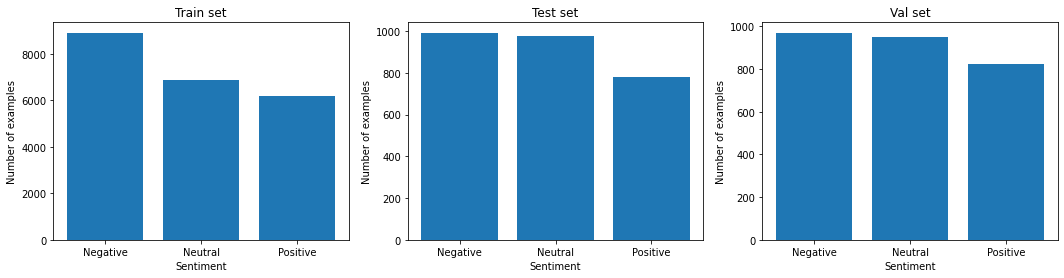

In [ ]:
from plot_utils import plot_example_distribution

plot_example_distribution(df_train,df_test,df_val)

Number of examples per class are not equal, but the dataset is fairly balanced. So we can use an accuracy as the metric for our classifier.

In [ ]:
from dataset_utils import schuffle_df

df_train = schuffle_df(df_train)
print(df_train.head())
df_val = schuffle_df(df_val)
print(df_val.head())
df_test = schuffle_df(df_test)
print(df_test.head())

            TweetID  ...      Lang
13103  4.432116e+17  ...  Croatian
12401  4.412091e+17  ...  Croatian
6273   4.249930e+17  ...   Serbian
16217  4.620899e+17  ...  Croatian
18407  4.683822e+17  ...  Croatian

[5 rows x 5 columns]
           TweetID  ...      Lang
1349  4.916636e+17  ...  Croatian
104   4.289211e+17  ...   Serbian
2152  4.944184e+17  ...  Croatian
1484  4.918341e+17  ...  Croatian
2741  4.099930e+17  ...   Bosnian

[5 rows x 5 columns]
           TweetID  ...      Lang
349   4.326081e+17  ...   Serbian
151   4.313584e+17  ...   Serbian
1371  4.969874e+17  ...  Croatian
896   4.342567e+17  ...   Serbian
1726  4.998508e+17  ...  Croatian

[5 rows x 5 columns]


In [ ]:
df_train.to_csv(os.path.join(data_path,'train.csv'))
df_val.to_csv(os.path.join(data_path,'val.csv'))
df_test.to_csv(os.path.join(data_path,'test.csv'))

## Load XLM-R model and sentencepiece tokenizer

For this task we will use XLM-R large model, which can be downloaded from pytorch hub and sentencepiece tokenizer which can be downloaded from hugging face package. 

Install dependencies for fairseq

In [ ]:
%pip install hydra-core
%pip install omegaconf
%pip install sentencepiece
%pip install transformers

Load XLM-R model

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from statistics import mean
import pickle

xlmr = torch.hub.load('pytorch/fairseq', 'xlmr.large')

Load sentencepiece tokenizer

In [ ]:
from transformers import XLMRobertaTokenizer, AdamW, get_linear_schedule_with_warmup

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")

## Complete model

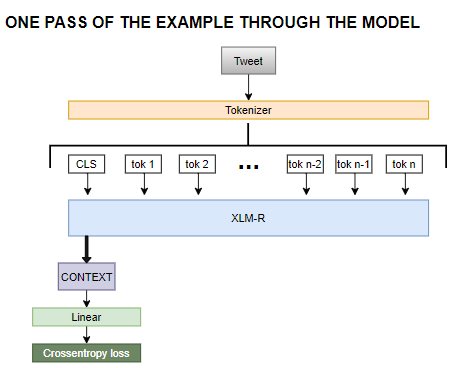

## Hyperparameters

In [ ]:
BATCH_SIZE = 8
EPOCHS = 25 # total number of epochs
DO = 0.2 # dropout
#=============================
# freeze xlmr hyperparams 
EPOCHS_FREEZE = 2
NUM_WARMUP_EPOCHS_FREEZE = 1
LR_FREEZE = 1e-4
#=============================
# unfreeze xlmr hyperparams
NUM_WARMUP_EPOCHS = 4
WEIGHT_DECAY = 1e-3
LR = 1e-6

## Train loop

In [ ]:
from dataset import MyDataset
from model_utils import wrap_tokenizer, train_step, val_step
from checkpoint_utils import save_to_disk, load_from_disk
from checkpoint_utils import save_checkpoint_dataset1 as save_checkpoint

In [ ]:
checkpoint_dir = os.path.join(os.getcwd(),'checkpoints','dataset1')
os.makedirs(checkpoint_dir, exist_ok=True)
print(f'Checkpoints will be saved at {checkpoint_dir}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
xlmr = xlmr.to(device)
classifier = nn.Linear(in_features=1024, out_features=3).to(device)
dropout = nn.Dropout(p=DO).to(device)
print('Number of trainable params: ',sum(p.numel() for p in xlmr.parameters())+\
      sum(p.numel() for p in classifier.parameters()))
# define Data Loaders
train_dataset = MyDataset(df_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = MyDataset(df_val)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = MyDataset(df_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# define optimizer
params = list(xlmr.parameters()) + list(classifier.parameters())
# start with frozen XLMR model (it should be left in train mode)
for p in xlmr.parameters():
    p.requires_grad=False
optimizer = AdamW(params, lr=LR_FREEZE)
# define learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=NUM_WARMUP_EPOCHS_FREEZE*len(train_loader),
    num_training_steps=EPOCHS_FREEZE*len(train_loader)
    )
# wrap tokenizer
tokenize = wrap_tokenizer(tokenizer)
logs = {'train_acc':[],'train_loss':[],'val_acc':[],'val_loss':[], 'lr':[]}
for epoch in range(EPOCHS):
    if epoch == EPOCHS_FREEZE:
        # unfreeze xlmr model
        for p in xlmr.parameters():
            p.requires_grad=True
        print('XLM-R model is unfrozen!')
        optimizer = AdamW(params, lr=LR, weight_decay=WEIGHT_DECAY)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=NUM_WARMUP_EPOCHS*len(train_loader),
            num_training_steps=(EPOCHS-EPOCHS_FREEZE)*len(train_loader)
            )
    train_acc, train_loss = train_step(
        train_loader=train_loader,
        tokenize=tokenize, 
        device=device, 
        optimizer=optimizer, 
        scheduler=scheduler,
        xlmr=xlmr,
        classifier=classifier,
        dropout = dropout,
        logs=logs
        )
    val_acc, val_loss = val_step(
        val_loader=val_loader,
        tokenize=tokenize, 
        device=device, 
        xlmr=xlmr,
        classifier=classifier,
        dropout=dropout
        )
    logs['train_acc'] += train_acc
    logs['train_loss'] += train_loss
    logs['val_acc'] += val_acc
    logs['val_loss'] += val_loss
    if epoch % 2 == 0 and epoch != 0 :
        save_checkpoint(
            xlmr=xlmr,
            classifier=classifier, 
            optimizer=optimizer, 
            logs=logs, 
            checkpoint_dir=checkpoint_dir, 
            epoch=epoch
            )
    print('')
    print(f"Epoch {epoch} --> loss:{mean(train_loss):.4f},\
        acc:{mean(train_acc):.2f}%,\
        val_loss:{mean(val_loss):.4f},\
        val_acc:{mean(val_acc):.2f}%")

## Test

In [ ]:
test_acc, test_loss,_,_ = val_step(
        val_loader=test_loader,
        tokenize=tokenize, 
        device=device, 
        xlmr=xlmr,
        classifier=classifier,
        dropout,
        is_test=True
        )
print('')
print(f"test loss:{mean(test_loss):.4f}\n test acc:{mean(test_acc):.2f}%")

Validating...
 iter: 344/344
test loss:1.0446
 test acc:0.63%


The reason for this small accuracy can be found in the paper referenced at the top, and it is a consequence of the low quality of the dataset. We have achieved accuracy greater than the one in the paper (keep in mind that they used larger dataset, so these results are not quite comparable), so we can conclude that the analysis is successfull.


## Plot training curves

Load logs from checkpoint

In [ ]:
import os
from plot_utils import *

checkpoint_path = os.path.join(os.getcwd(),'checkpoints','dataset1','best') 
logs = load_from_disk(os.path.join(checkpoint_path,'logs.txt'))

Plot learning rate schedule

Text(22000, 8e-05, 'Fine-Tuning')

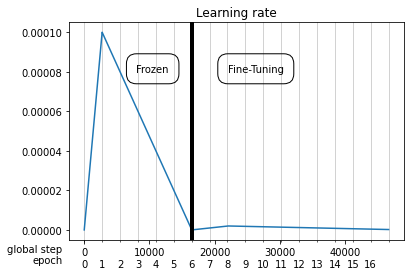

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(logs['lr'])
ax.set_title('Learning rate')
minor_ticks = np.arange(-1, 2744*17, 2744)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(labels=range(0,17),minor=True)
ax.grid(which='minor', alpha=0.7)
xax = ax.get_xaxis()
ax.set_xlabel('global step\nepoch',labelpad=-25,horizontalalignment='right', x=-0.02)
xax.set_tick_params(which='minor', pad=17)
ax.axvline(x=6*2744, linewidth=4, color='black')
ax.text(8000, 0.00008, 'Frozen', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
ax.text(22000, 0.00008, 'Fine-Tuning', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

Plot accuracy

Text(22000, 8.5e-05, 'Fine-Tuning')

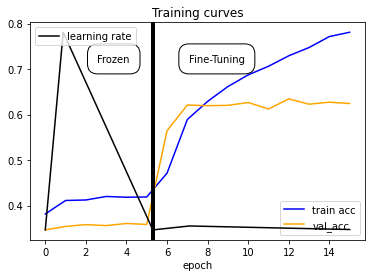

In [ ]:
fig = plt.figure()
ax1=fig.add_subplot(111, label="1")
l1,=ax1.plot(average(logs['train_acc'],2744)[:16],color='blue')
l2,=ax1.plot(average(logs['val_acc'],343)[:16],color='orange')
ax1.legend(['train acc','val_acc'],loc='lower right')
ax=fig.add_subplot(111, label="3",frame_on=False)
ax.plot(logs['lr'], color='black')
ax.set_title('Training curves')
#ax.set_xlabel('epoch')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.legend(['learning rate'],loc='upper left')
plt.xlabel('epoch',labelpad=20)
ax.axvline(x=6*2744, linewidth=4, color='black')
ax.text(8000, 0.000085, 'Frozen', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
ax.text(22000, 0.000085, 'Fine-Tuning', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))